In [1]:

# ======================
# 标准库
# ======================
from pathlib import Path
import json
import multiprocessing
from typing import Dict, Tuple

# ======================
# 第三方库
# ======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import galsim

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ZScaleInterval
from astropy.wcs import WCS
import astropy.units as u

from photutils.detection import DAOStarFinder

from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import util
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Analysis.image_reconstruction import MultiBandImageReconstruction as Reconstruction

# ======================
# 自定义模块
# ======================
import lensviz_new_3 as lv



# ========= 0. 基础配置 =========
ROOT          = Path("/home/zizhao/jasmine-worksapce/FH2")
IMG_DIR       = ROOT / "hsc-fitscutout"
PSF_DIR       = ROOT / "hsc-psf"          # 与 cutout 同一像素标尺
RES_DIR       = ROOT / "result-single-model"  

DEFAULT_PIXSCALE = 0.168                  
SPECID   = "hsc39627781180490339"          # <- replace with your SPECID
ra_cen=148.529041
dec_cen=-0.373677



def RaDec2XY(ra_arr, dec_arr, ra_c, dec_c, image_size):
    pixel_hsc=DEFAULT_PIXSCALE
    image      = galsim.Image(image_size, image_size)
    cen_coord  = galsim.CelestialCoord(ra_c * galsim.degrees, dec_c * galsim.degrees)
    affine_wcs = galsim.PixelScale(pixel_hsc).affine().shiftOrigin(image.center)
    wcs        = galsim.TanWCS(affine_wcs, world_origin=cen_coord)
    image.wcs  = wcs
    x_mbr_arr  = np.array([])
    y_mbr_arr  = np.array([])

    for ra, dec in zip(ra_arr, dec_arr):
        coord      = galsim.CelestialCoord(ra*galsim.degrees, dec*galsim.degrees)
        image_pos  = wcs.toImage(coord)
        x_mbr_arr  = np.append(x_mbr_arr, image_pos.x)
        y_mbr_arr  = np.append(y_mbr_arr, image_pos.y)
        
    return (x_mbr_arr, y_mbr_arr)


from typing import Union
import math

def radec_to_jname(ra_deg: Union[float, int],
                   dec_deg: Union[float, int]) -> str:
    """
    将 RA、Dec（单位：度）转换为 IAU 命名格式 JHHMM±DDMM。

    参数
    ----
    ra_deg  : float | int
        赤经，度制 (0 ≤ RA < 360)。
    dec_deg : float | int
        赤纬，度制 (−90 ≤ Dec ≤ +90)。

    返回
    ----
    str
        形如 'J0954+0323' 或 'J1234-0456' 的字符串。
    """
    # -------- RA → HHMM --------
    ra_hours = ra_deg / 15.0                     # 度 → 时
    hh = int(math.floor(ra_hours))               # 截断到整时
    mm = int(math.floor((ra_hours - hh) * 60.))  # 剩余部分转为整分

    # -------- Dec → ±DDMM --------
    sign = '+' if dec_deg >= 0 else '-'
    dec_abs = abs(dec_deg)
    dd = int(math.floor(dec_abs))                # 截断到整度
    dm = int(math.floor((dec_abs - dd) * 60.))   # 剩余部分转为整分

    return f"J{hh:02d}{mm:02d}{sign}{dd:02d}{dm:02d}"

/home/zizhao/anaconda3/envs/py38/lib/python3.8/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


Source 1: RA=148.529007, Dec=-0.374008
Source 2: RA=148.529047, Dec=-0.373670


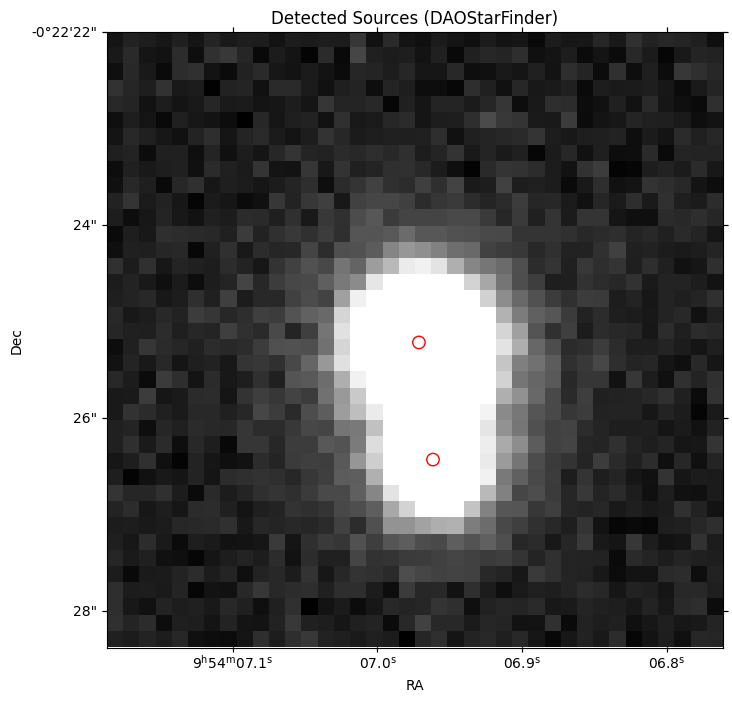

In [2]:


# 文件路径
file_path = IMG_DIR / f"{SPECID}_g.fits"

# 读取 FITS 文件
hdul = fits.open(file_path)
data = hdul[1].data  # 图像数据
header = hdul[1].header
wcs = WCS(header)

# 背景统计
mean, median, std = sigma_clipped_stats(data, sigma=3.0)

# 用 DAOStarFinder 找星
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(data - median)

# 绘图
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': wcs}, figsize=(8, 8))
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(data)
ax.imshow(data, origin='lower', vmin=vmin, vmax=vmax, cmap='gray')

if sources is not None:
    ax.scatter(sources['xcentroid'], sources['ycentroid'],
            transform=ax.get_transform('pixel'), s=80, edgecolor='red', facecolor='none')

ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.title("Detected Sources (DAOStarFinder)")

# 像素 → 天球坐标
if sources is not None:
    sky_coords = wcs.pixel_to_world(sources['xcentroid'], sources['ycentroid'])
    ra_dec_list = [(sky.ra.deg, sky.dec.deg) for sky in sky_coords]
    for i, (ra, dec) in enumerate(ra_dec_list):
        print(f"Source {i+1}: RA={ra:.6f}, Dec={dec:.6f}")

hdul.close()

In [3]:
ra1=ra_dec_list[0][0]
dec1=ra_dec_list[0][1]
ra2=ra_dec_list[1][0]
dec2=ra_dec_list[1][1]

In [4]:
def Caculate_sep(ra_arr, dec_arr):
    coords = {}
    i = 1
    for ra, dec in zip(ra_arr, dec_arr):
        coords[f"c_{i}"] = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame="fk5")
        i += 1

    if i - 1 == 2:
        sep = coords["c_1"].separation(coords["c_2"])
        sep_arcsec = sep.arcsecond
        return sep_arcsec
    elif i - 1 == 3:
        sep1 = coords["c_1"].separation(coords["c_2"])
        sep1_arcsec = sep1.arcsecond  
        sep2 = coords["c_1"].separation(coords["c_3"])
        sep2_arcsec = sep2.arcsecond    
        sep3 = coords["c_2"].separation(coords["c_3"])
        sep3_arcsec = sep3.arcsecond 
        return max(sep1_arcsec, sep2_arcsec, sep3_arcsec)
    else:
        print("Nqso larger than 3, it is: ", i)
        assert False

In [5]:
sep=Caculate_sep([ra1,ra2],[dec1,dec2])
print(sep)

1.2224992846598959


In [6]:
from typing import Union
import math

def radec_to_jname(ra_deg: Union[float, int],
                   dec_deg: Union[float, int]) -> str:
    """
    将 RA、Dec（单位：度）转换为 IAU 命名格式 JHHMM±DDMM。

    参数
    ----
    ra_deg  : float | int
        赤经，度制 (0 ≤ RA < 360)。
    dec_deg : float | int
        赤纬，度制 (−90 ≤ Dec ≤ +90)。

    返回
    ----
    str
        形如 'J0954+0323' 或 'J1234-0456' 的字符串。
    """
    # -------- RA → HHMM --------
    ra_hours = ra_deg / 15.0                     # 度 → 时
    hh = int(math.floor(ra_hours))               # 截断到整时
    mm = int(math.floor((ra_hours - hh) * 60.))  # 剩余部分转为整分

    # -------- Dec → ±DDMM --------
    sign = '+' if dec_deg >= 0 else '-'
    dec_abs = abs(dec_deg)
    dd = int(math.floor(dec_abs))                # 截断到整度
    dm = int(math.floor((dec_abs - dd) * 60.))   # 剩余部分转为整分

    return f"J{hh:02d}{mm:02d}{sign}{dd:02d}{dm:02d}"

def _read_band(path: Path) -> Tuple[np.ndarray, np.ndarray]:
    """
    返回 (image, noise_map)

    假设：
      * SCI 数据在 HDU 1（从 0 开始计数）
      * VAR 方差图在 HDU 3
    """
    with fits.open(path) as hdul:
        img = hdul[1].data.astype(np.float32)            # 科学图像
        var = hdul[3].data.astype(np.float32)            # 方差图
    var[var <= 0] = np.nan                               # 防止负值/零
    noise_map = np.sqrt(var)                             # σ = √Var
    return img, noise_map


# ---------------------------------------------------------------------------
# Load all three bands
# ---------------------------------------------------------------------------
images:     Dict[str, np.ndarray] = {}
noise_maps: Dict[str, np.ndarray] = {}

for band in ("g", "i", "r"):
    fp = IMG_DIR / f"{SPECID}_{band}.fits"
    if not fp.exists():
        raise FileNotFoundError(fp)
    images[band], noise_maps[band] = _read_band(fp)
    print(f"{band}-band: image shape {images[band].shape}, noise_map OK")

g-band: image shape (38, 38), noise_map OK
i-band: image shape (38, 38), noise_map OK
r-band: image shape (38, 38), noise_map OK


In [7]:
jname=radec_to_jname(ra_cen,dec_cen)
print(jname)

J0954-0022


In [8]:
# from lensing_gal_marker import Marker

# m = Marker(IMG_DIR / f"{SPECID}_i.fits")  # 支持 ~ 与相对/绝对路径
# m.display()                            # 打开交互图
# # 点击若干次后：
# m.coords                               # 查看 [(RA1, Dec1), (RA2, Dec2), ...]


In [9]:
# m.save_coords(f"my_clicks-{jname}.csv")         # 可将坐标保存成 CSV
# m.disconnect()                         # 若想停止监听

In [10]:
t=pd.read_csv(f"my_clicks-{jname}.csv")
ra_gal=t['ra'].tolist()[0]
dec_gal=t['dec'].tolist()[0]
print(ra_gal,dec_gal)

148.52903803560355 -0.3737858020757118


In [11]:
def crop_center_N(arr: np.ndarray, N: int) -> np.ndarray:
    """
    将任意尺寸的矩阵/图像裁剪为中心 N×N 区域，N 必须为奇数。
    仅裁剪最后两维 (H, W)，其余维度保持不变。

    Parameters
    ----------
    arr : np.ndarray
        输入数组，至少 2 维。
    N : int
        裁剪后的边长，必须为奇数且 > 0。

    Returns
    -------
    np.ndarray
        裁剪后的数组，最后两维为 (N, N)。
    """
    if arr.ndim < 2:
        raise ValueError("输入至少应为 2 维矩阵")
    if N <= 0 or (N % 2 == 0):
        raise ValueError("N 必须为正奇数")

    H, W = arr.shape[-2], arr.shape[-1]
    if H < N or W < N:
        raise ValueError(f"输入尺寸 ({H}, {W}) 过小，无法裁剪 {N}×{N}")

    y1 = (H - N) // 2
    x1 = (W - N) // 2
    y2 = y1 + N
    x2 = x1 + N

    return arr[..., y1:y2, x1:x2] if arr.ndim > 2 else arr[y1:y2, x1:x2]


def show_cutout_nice(data, pixscale=0.168, ra_left=True,
                    xgal=None, ygal=None, x1=None, y1=None, x2=None, y2=None,
                    title=None, add_contour=True):
    """
    data: 2D 图像数组（像素）
    pixscale: 角秒/像素
    ra_left: True 时将 RA 轴朝左（天图常规）
    x*, y*: 已换算成弧秒的坐标（相对图像中心）
    """
    ny, nx = data.shape
    half = 0.5 * np.array([nx, ny]) * pixscale  # (x_half_as, y_half_as)

    # 背景与拉伸（分位数+可选 asinh）
    bg = np.nanmedian(data)
    d0 = data - bg
    vmin, vmax = np.nanpercentile(d0, [1, 99.5])
    # 温和的 asinh 拉伸（不改变 photometry，只用于显示）
    stretch = np.arcsinh(d0 / max(1e-6, (vmax - vmin) / 3.0))

    fig, ax = plt.subplots(figsize=(4.8, 4.8), dpi=160)
    im = ax.imshow(
        stretch,
        origin="lower",
        extent=[-half[0], half[0], -half[1], half[1]],
        cmap="cividis",  # 颜色友好且层次清晰
        interpolation="nearest",
    )

    # 可选等高线（自动回退，无 SciPy 也能跑）
    if add_contour:
        try:
            from scipy.ndimage import gaussian_filter
            sm = gaussian_filter(d0, 0.8)
        except Exception:
            sm = d0
        # 在正向范围内取 3 个等高线
        pos = sm[sm > 0]
        if pos.size > 20:
            lev = np.nanpercentile(pos, [70, 85, 95])
            ax.contour(
                sm, levels=lev, colors="white", linewidths=0.6,
                origin="lower",
                extent=[-half[0], half[0], -half[1], half[1]]
            )

    # 标记：Galaxy（橙）、A/B（绿/蓝）
    handles, labels = [], []
    if xgal is not None and ygal is not None:
        h = ax.scatter(xgal, ygal, s=36, marker="o", edgecolors="k", linewidths=0.5, color="orange")
        ax.annotate("Gal", (xgal, ygal), xytext=(4, 4), textcoords="offset points", fontsize=9)
        handles.append(h); labels.append("Galaxy")
    if x1 is not None and y1 is not None:
        h = ax.scatter(x1, y1, s=28, marker="o", edgecolors="k", linewidths=0.4, color="limegreen")
        ax.annotate("A", (x1, y1), xytext=(4, 4), textcoords="offset points", fontsize=9)
        handles.append(h); labels.append("Image A")
    if x2 is not None and y2 is not None:
        h = ax.scatter(x2, y2, s=28, marker="o", edgecolors="k", linewidths=0.4, color="dodgerblue")
        ax.annotate("B", (x2, y2), xytext=(4, 4), textcoords="offset points", fontsize=9)
        handles.append(h); labels.append("Image B")

    # 轴与色条
    ax.set_aspect("equal")
    if ra_left:
        ax.invert_xaxis()
    ax.set_xlabel(r"$\Delta$RA (arcsec)")
    ax.set_ylabel(r"$\Delta$Dec (arcsec)")
    if title:
        ax.set_title(title, fontsize=11, pad=6)

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("asinh-stretched counts", rotation=90)
    if handles:
        ax.legend(handles, labels, loc="upper right", frameon=True, framealpha=0.8, fontsize=9)

    ax.tick_params(direction="in", length=4, width=0.8, top=True, right=True)
    fig.tight_layout()
    return fig, ax

In [12]:
data_g=crop_center_N(images['g'],33)
data_r=crop_center_N(images['r'],33)
data_i=crop_center_N(images['i'],33)

In [13]:
rms_map_g=crop_center_N(noise_maps['g'],33)
rms_map_r=crop_center_N(noise_maps['r'],33)
rms_map_i=crop_center_N(noise_maps['i'],33)

In [14]:
with fits.open(PSF_DIR/f"{SPECID}_g.fits") as hdul:
    psf_g=hdul[0].data.astype(np.float32)
with fits.open(PSF_DIR/f"{SPECID}_r.fits") as hdul:
    psf_r=hdul[0].data.astype(np.float32)
with fits.open(PSF_DIR/f"{SPECID}_i.fits") as hdul:
    psf_i=hdul[0].data.astype(np.float32)

In [15]:
psf_g=crop_center_N(psf_g,33)
psf_r=crop_center_N(psf_r,33)
psf_i=crop_center_N(psf_i,33)

In [16]:
print(ra1,ra2,ra_gal,ra_cen)
print(dec1,dec2,dec_gal,dec_cen)

148.5290065305949 148.52904695852325 148.52903803560355 148.529041
-0.37400752939962784 -0.37367036125535563 -0.3737858020757118 -0.373677


In [17]:
scl=(len(rms_map_r)+1)/2
x_pix, y_pix = RaDec2XY([ra1,ra2,ra_gal], [dec1,dec2,dec_gal], ra_cen, dec_cen,2*scl-1)

x1=(x_pix[0]-scl)*DEFAULT_PIXSCALE
x2=(x_pix[1]-scl)*DEFAULT_PIXSCALE
xgal=(x_pix[2]-scl)*DEFAULT_PIXSCALE
y1=(y_pix[0]-scl)*DEFAULT_PIXSCALE
y2=(y_pix[1]-scl)*DEFAULT_PIXSCALE
ygal=(y_pix[2]-scl)*DEFAULT_PIXSCALE

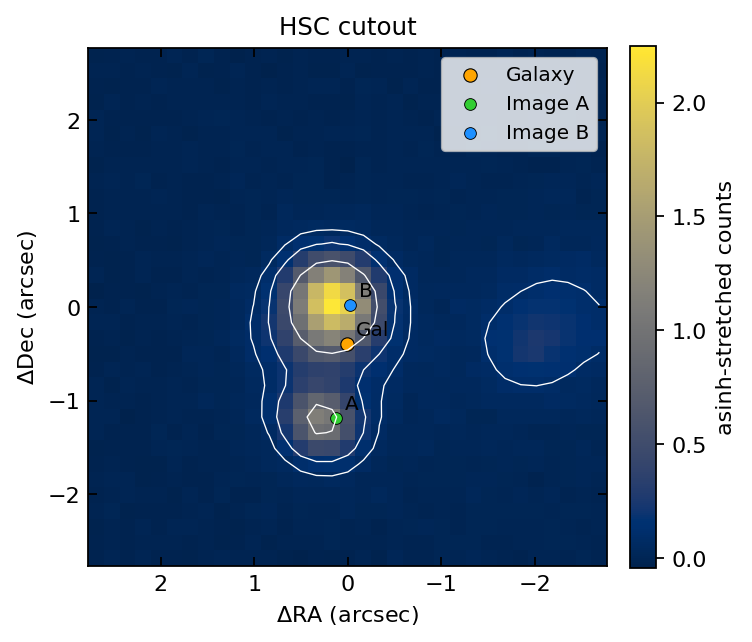

In [18]:
# 图像像素 -> 角秒的标记坐标
# 假设你已有 xgal,ygal,x1,y1,x2,y2（单位本身就是 arcsec）
fig, ax = show_cutout_nice(
    data_i, pixscale=DEFAULT_PIXSCALE, ra_left=True,
    xgal=xgal, ygal=ygal, x1=x1, y1=y1, x2=x2, y2=y2,
    title="HSC cutout"
)

In [19]:
# from pixmasker import MaskEditor
# %matplotlib widget
# editor = MaskEditor(
#     data_i,
#     stretch="asinh",       # 可选: 'linear' 或 'asinh'
#     percent_lo=1, percent_hi=99,  # 自动计算显示范围
#     # cmap="gray",         # 如需灰度可手动设置；默认用 matplotlib 的默认 colormap
#     brush_radius=5,        # 画笔半径（像素）
#     default_save_path="mask.npy"  # 按 s 快捷键默认保存位置
# )

# editor.show()

In [20]:
# editor.close()

In [21]:
mask = np.load(f"mask-{jname}.npy").astype(bool)   # True=屏蔽
assert mask.shape == data_i.shape, f"mask shape {mask.shape} != image {data_i.shape}"
rms_map_g[mask]= 1e9
rms_map_r[mask]= 1e9
rms_map_i[mask]= 1e9

In [22]:
deltaPix_g=DEFAULT_PIXSCALE
numPix_g=data_g.shape[0]
psf_type_g='PIXEL'

_, _, ra_at_xy_0_g, dec_at_xy_0_g, _, _, Mpix2coord_g, _ = util.make_grid_with_coordtransform(numPix=numPix_g, deltapix=deltaPix_g, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

kwargs_data_g = {'noise_map': rms_map_g,  # rms of background noise
            'exposure_time': 600,  # exposure time (or a map per pixel)
            'ra_at_xy_0': ra_at_xy_0_g,  # RA at (0,0) pixel
            'dec_at_xy_0': dec_at_xy_0_g,  # DEC at (0,0) pixel 
            'transform_pix2angle': Mpix2coord_g,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
            'image_data': data_g,  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
            }


kwargs_psf_g={'psf_type': psf_type_g, 'kernel_point_source': psf_g, 'pixel_size': deltaPix_g}


kwargs_numerics_g = {'supersampling_factor': 4, 'supersampling_convolution': False}


In [23]:
#r_data_set
deltaPix_r=DEFAULT_PIXSCALE
numPix_r=data_r.shape[0]
psf_type_r='PIXEL'

_, _, ra_at_xy_0_r, dec_at_xy_0_r, _, _, Mpix2coord_r, _ = util.make_grid_with_coordtransform(numPix=numPix_r, deltapix=deltaPix_r, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

kwargs_data_r = {'noise_map': rms_map_r,  # rms of background noise
            'exposure_time': 600,  # exposure time (or a map per pixel)
            'ra_at_xy_0': ra_at_xy_0_r,  # RA at (0,0) pixel
            'dec_at_xy_0': dec_at_xy_0_r,  # DEC at (0,0) pixel 
            'transform_pix2angle': Mpix2coord_r,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
            'image_data': data_r,  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
            }


kwargs_psf_r={'psf_type': psf_type_r, 'kernel_point_source': psf_r, 'pixel_size': deltaPix_r}


kwargs_numerics_r = {'supersampling_factor': 4, 'supersampling_convolution': False}

In [24]:
#z_data_set
deltaPix_i=DEFAULT_PIXSCALE
numPix_i=data_i.shape[0]
psf_type_i='PIXEL'

_, _, ra_at_xy_0_i, dec_at_xy_0_i, _, _, Mpix2coord_i, _ = util.make_grid_with_coordtransform(numPix=numPix_i, deltapix=deltaPix_i, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

kwargs_data_i = {'noise_map': rms_map_i,  # rms of background noise
            'exposure_time': 600,  # exposure time (or a map per pixel)
            'ra_at_xy_0': ra_at_xy_0_i,  # RA at (0,0) pixel
            'dec_at_xy_0': dec_at_xy_0_i,  # DEC at (0,0) pixel 
            'transform_pix2angle': Mpix2coord_i,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
            'image_data': data_i,  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
            }

kwargs_psf_i={'psf_type': psf_type_i, 'kernel_point_source': psf_i, 'pixel_size': deltaPix_i}

kwargs_numerics_i = {'supersampling_factor': 4, 'supersampling_convolution': False}

In [25]:
#multi_band_data
multi_band_list = [[kwargs_data_g, kwargs_psf_g, kwargs_numerics_g],[kwargs_data_r, kwargs_psf_r, kwargs_numerics_r],[kwargs_data_i, kwargs_psf_i, kwargs_numerics_i]]

In [26]:
#multi_band_joint
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear' }

In [27]:
#kwargs_model
lens_light_model_list = ['SERSIC_ELLIPSE']*3
point_source_list = ['UNLENSED'] 

#index_model_list
index_lens_light_model_list = [[0],[1],[2]]
index_point_source_model_list = [[0], [0], [0]] 

kwargs_model = dict(
    lens_light_model_list = lens_light_model_list,
    point_source_model_list = point_source_list,
    index_lens_light_model_list = index_lens_light_model_list,
    index_point_source_model_list = index_point_source_model_list,
)

#kwargs_likelihood
kwargs_likelihood = {'check_bounds': True, 'source_marg': False,'bands_compute': [True,True,True], 'check_positive_flux':True}

#kwargs_lens_light_params
kwargs_fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

In [28]:
#add g lens_light
kwargs_fixed_lens_light.append({'n_sersic':4})
kwargs_lens_light_init.append({'R_sersic': 1.0, 'e1': 0.01, 'e2': 0.01, 'center_x': xgal, 'center_y': ygal})
kwargs_lens_light_sigma.append({ 'R_sersic': 0.01,'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.05})
kwargs_lower_lens_light.append({'R_sersic': 0.1,'e1': -0.5, 'e2': -0.5, 'center_x': xgal-sep/4, 'center_y':ygal-sep/4})
kwargs_upper_lens_light.append({'R_sersic': 2,'e1': 0.5, 'e2': 0.5, 'center_x':  xgal+sep/4, 'center_y': ygal+sep/4})

#add r lens_light
kwargs_fixed_lens_light.append({'n_sersic':4})
kwargs_lens_light_init.append({'R_sersic': 1.0, 'e1': 0.01, 'e2': 0.01, 'center_x': xgal, 'center_y': ygal})
kwargs_lens_light_sigma.append({ 'R_sersic': 0.01,'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.05})
kwargs_lower_lens_light.append({'R_sersic': 0.1,'e1': -0.5, 'e2': -0.5, 'center_x': xgal-sep/4, 'center_y':ygal-sep/4})
kwargs_upper_lens_light.append({'R_sersic': 2,'e1': 0.5, 'e2': 0.5, 'center_x':  xgal+sep/4, 'center_y': ygal+sep/4})

#add z lens_light
kwargs_fixed_lens_light.append({'n_sersic':4})
kwargs_lens_light_init.append({'R_sersic': 1.0, 'e1': 0.01, 'e2': 0.01, 'center_x': xgal, 'center_y': ygal})
kwargs_lens_light_sigma.append({ 'R_sersic': 0.01,'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.05})
kwargs_lower_lens_light.append({'R_sersic': 0.1,'e1': -0.5, 'e2': -0.5, 'center_x': xgal-sep/4, 'center_y':ygal-sep/4})
kwargs_upper_lens_light.append({'R_sersic': 2,'e1': 0.5, 'e2': 0.5, 'center_x':  xgal+sep/4, 'center_y': ygal+sep/4})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

#add point
kwargs_fixed_ps = []
kwargs_ps_init = []
kwargs_ps_sigma = []
kwargs_lower_ps = []
kwargs_upper_ps = []


kwargs_ps_init  = [{'ra_image':[x1,x2], 'dec_image':[y1,y2]}]  # 2 个像
kwargs_ps_sigma = [{'ra_image':[0.02]*2, 'dec_image':[0.02]*2}]
kwargs_fixed_ps = [{}]          # 不固定振幅；线性求解器会加 point_amp
kwargs_lower_ps = [{'ra_image':[x1-DEFAULT_PIXSCALE,x2-DEFAULT_PIXSCALE], 'dec_image':[y1-DEFAULT_PIXSCALE,y2-DEFAULT_PIXSCALE]}]
kwargs_upper_ps = [{'ra_image':[x1+DEFAULT_PIXSCALE,x2+DEFAULT_PIXSCALE], 'dec_image':[y1+DEFAULT_PIXSCALE,y2+DEFAULT_PIXSCALE]}]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {
            'lens_light_model': lens_light_params,
            'point_source_model': ps_params}

kwargs_constraints = {
                'joint_lens_light_with_lens_light':[[0, 1, ['center_x', 'center_y', 'e1','e2']],[0,2,['center_x', 'center_y', 'e1','e2']]],
                'num_point_source_list': [2]}





In [29]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

threadcount=100

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100, 'threadCount': threadcount}], 
                    ['MCMC', {'n_burn': 50, 'n_run': 50, 'walkerRatio': 10,'sigma_scale': .1,'threadCount': threadcount}]]

# fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 300, 'n_iterations': 300, 'threadCount': threadcount}], 
#                        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

/home/zizhao/anaconda3/envs/py38/lib/python3.8/site-packages/lenstronomy/Data/psf.py:60: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn('Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.')


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.6425344636840158 reduced X^2 of best position
-2666.6547017909998 log likelihood
3247.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.035223993872562, 'n_sersic': 4, 'e1': 0.24639185175025952, 'e2': 0.13102533872473573, 'center_x': 0.3152844963675863, 'center_y': -0.3564951602754647}, {'amp': 1, 'R_sersic': 1.003621990495469, 'n_sersic': 4, 'e1': 0.24639185175025952, 'e2': 0.13102533872473573, 'center_x': 0.3152844963675863, 'center_y': -0.3564951602754647}, {'amp': 1, 'R_sersic': 0.8529665496896652, 'n_sersic': 4, 'e1': 0.24639185175025952, 'e2': 0.13102533872473573, 'center_x': 0.3152844963675863, 'center_y': -0.3564951602754647}] lens light result
[{'ra_image': array([0.27837764, 0.14176968]), 'dec_image': array([-1.22921019,  0.04973887]), 'point_amp': array([1., 1.])}] point source result
{} special param result
148.87637591362 time used for  PSO


/home/zizhao/anaconda3/envs/py38/lib/python3.8/site-packages/lenstronomy/Data/psf.py:60: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn('Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.')
100%|██████████| 100/100 [02:30<00:00,  1.50s/it]

Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  50
Sampling iterations (in current run): 100
151.67462491989136 time taken for MCMC sampling


In [30]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="viridis")
print(kwargs_result)

-1.6146859047142543 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9573762785276216
reduced chi^2 of data  1 =  1.0093463787978287
reduced chi^2 of data  2 =  2.8773350568173117
{'kwargs_lens': [], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 6.99284009077031e-05, 'R_sersic': 1.0325272766411377, 'n_sersic': 4, 'e1': 0.23553867345636487, 'e2': 0.12032237711532044, 'center_x': 0.3158233031872255, 'center_y': -0.3569820047174887}, {'amp': 1.2802849893635524, 'R_sersic': 1.0022508565483825, 'n_sersic': 4, 'e1': 0.23553867345636487, 'e2': 0.12032237711532044, 'center_x': 0.3158233031872255, 'center_y': -0.3569820047174887}, {'amp': 7.9272005465575335, 'R_sersic': 0.8514069857978224, 'n_sersic': 4, 'e1': 0.23553867345636487, 'e2': 0.12032237711532044, 'center_x': 0.3158233031872255, 'center_y': -0.3569820047174887}], 'kwargs_ps': [{'ra_image': array([0.2779394 , 0.14187018]), 'dec_image': array([-1.22357165,  0.

/home/zizhao/anaconda3/envs/py38/lib/python3.8/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)


In [31]:
#save chain

save_dir=Path(RES_DIR/f"ra_{ra_cen:.5f}_dec_{dec_cen:.5f}")
save_dir.mkdir(parents=True, exist_ok=True)


In [32]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

np.savetxt(save_dir/"samples_mcmc.txt",samples_mcmc)
np.savetxt(save_dir/"dist_mcmc.txt",dist_mcmc)

with open(save_dir/"param_mcmc.txt",'w') as f:
    json.dump(param_mcmc,f)

In [36]:
np.where(psf_g<0)

(array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  5,  7, 26, 27, 28, 28,
        29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 32, 32, 32, 32, 32, 32]),
 array([ 1,  3, 30,  2,  4, 31,  1, 30, 32,  0, 32,  0,  0, 32, 31, 31, 32,
        30, 32,  1, 26, 29, 31, 32,  2, 28, 30,  1,  6, 27, 29, 31, 32]))

In [33]:
# save g fits                  
numPix_s=37
deltaPix_s=0.168

model_data_g=modelPlot.saving_fits_files(numPix_s,deltaPix_s,band_index=0)

model_g=model_data_g[0]
source_g= model_data_g[1]
lens_g= model_data_g[2]
image_g= model_data_g[3]
norm_res_g=model_data_g[4]

fname_f=save_dir/'g_modeling.fits'

hdu_primary = fits.PrimaryHDU()
data_f=fits.ImageHDU(data_g,name='data')
model_f=fits.ImageHDU(model_g,name='model')
lens_f=fits.ImageHDU(lens_g,name='lens')
image_f=fits.ImageHDU(image_g,name='image')
source_f=fits.ImageHDU(source_g,name='source')
norm_res_f=fits.ImageHDU(norm_res_g,name='normalized residuals')
hdu_f=fits.HDUList([hdu_primary,data_f,model_f,lens_f,image_f,source_f,norm_res_f])

hdu_f.writeto(fname_f, overwrite=True)

# save r fits
model_data_r=modelPlot.saving_fits_files(numPix_s,deltaPix_s,band_index=1)

model_r=model_data_r[0]
source_r= model_data_r[1]
lens_r= model_data_r[2]
image_r= model_data_r[3]
norm_res_r=model_data_r[4]


fname_f=save_dir/'r_modeling.fits'

hdu_primary = fits.PrimaryHDU()
data_f=fits.ImageHDU(data_r,name='data')
model_f=fits.ImageHDU(model_r,name='model')
lens_f=fits.ImageHDU(lens_r,name='lens')
image_f=fits.ImageHDU(image_r,name='image')
source_f=fits.ImageHDU(source_r,name='source')
norm_res_f=fits.ImageHDU(norm_res_r,name='normalized residuals')
hdu_f=fits.HDUList([hdu_primary,data_f,model_f,lens_f,image_f,source_f,norm_res_f])

hdu_f.writeto(fname_f, overwrite=True)

# save z fits
model_data_i=modelPlot.saving_fits_files(numPix_s,deltaPix_s,band_index=2)

model_i=model_data_i[0]
source_i= model_data_i[1]
lens_i= model_data_i[2]
image_i= model_data_i[3]
norm_res_i=model_data_i[4]

fname_f=save_dir/'z_modeling.fits'

hdu_primary = fits.PrimaryHDU()
data_f=fits.ImageHDU(data_i,name='data')
model_f=fits.ImageHDU(model_i,name='model')
lens_f=fits.ImageHDU(lens_i,name='lens')
image_f=fits.ImageHDU(image_i,name='image')
source_f=fits.ImageHDU(source_i,name='source')
norm_res_f=fits.ImageHDU(norm_res_i,name='normalized residuals')
hdu_f=fits.HDUList([hdu_primary,data_f,model_f,lens_f,image_f,source_f,norm_res_f])

hdu_f.writeto(fname_f, overwrite=True)



#转化结果中的array以确保能够保存json文件
def numpy_to_dict(d):  
    """Recursively convert numpy arrays to lists in a dict."""  
    if isinstance(d, np.ndarray):  
        return d.tolist()  
    elif isinstance(d, dict):  
        return {k: numpy_to_dict(v) for k, v in d.items()}  
    elif isinstance(d, list):  
        return [numpy_to_dict(v) for v in d]  
    else:  
        return d 

# 转换 NumPy 数组  
kwargs_result = numpy_to_dict(kwargs_result) 
with open(save_dir/'kwargs_result.json','w') as f:
    json.dump(kwargs_result,f)
    


[lensviz] saved: result-single-model/ra_148.52904_dec_-0.37368/g_6panels_bwr.png


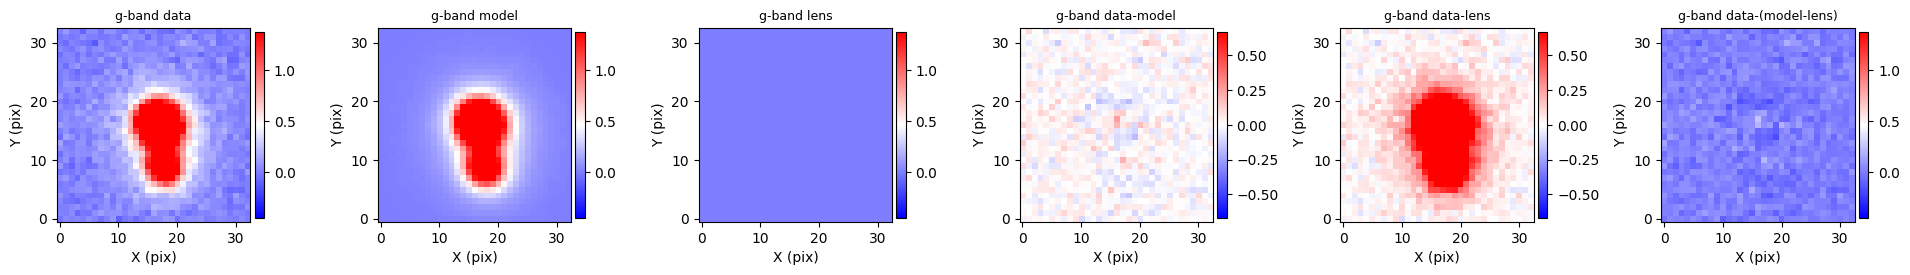

[lensviz] saved: result-single-model/ra_148.52904_dec_-0.37368/r_6panels_bwr.png


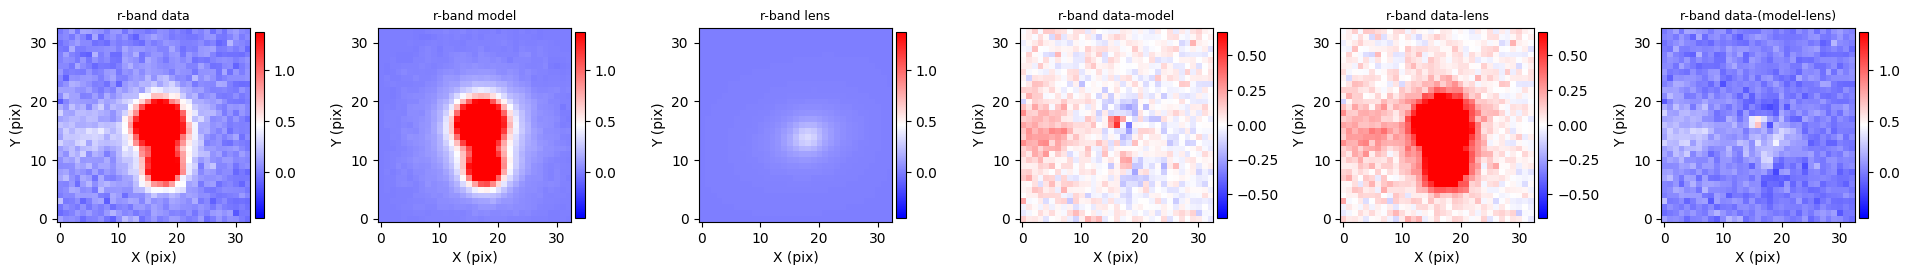

[lensviz] saved: result-single-model/ra_148.52904_dec_-0.37368/z_6panels_bwr.png


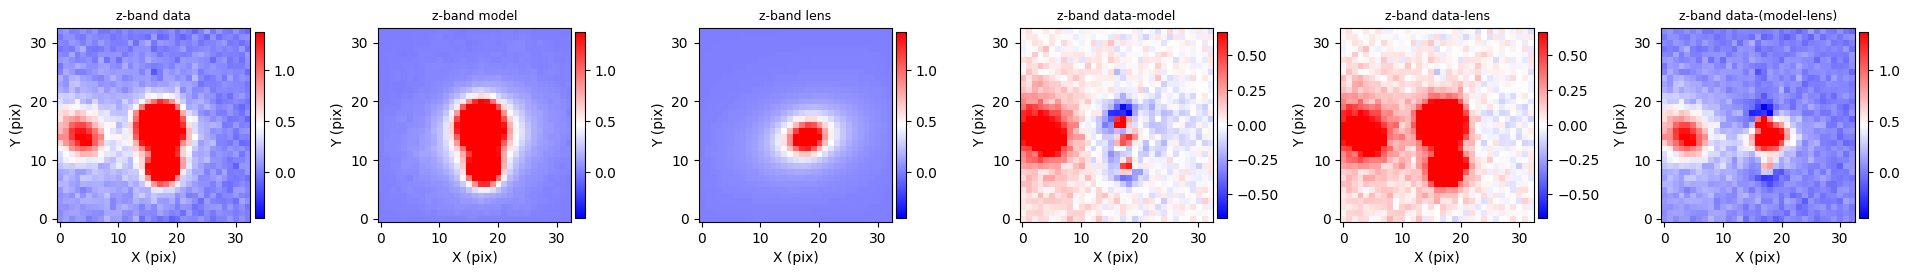

[lensviz] 已保存小图与拼接大图到: /home/zizhao/jasmine-worksapce/FH2/result-single-model/ra_148.52904_dec_-0.37368


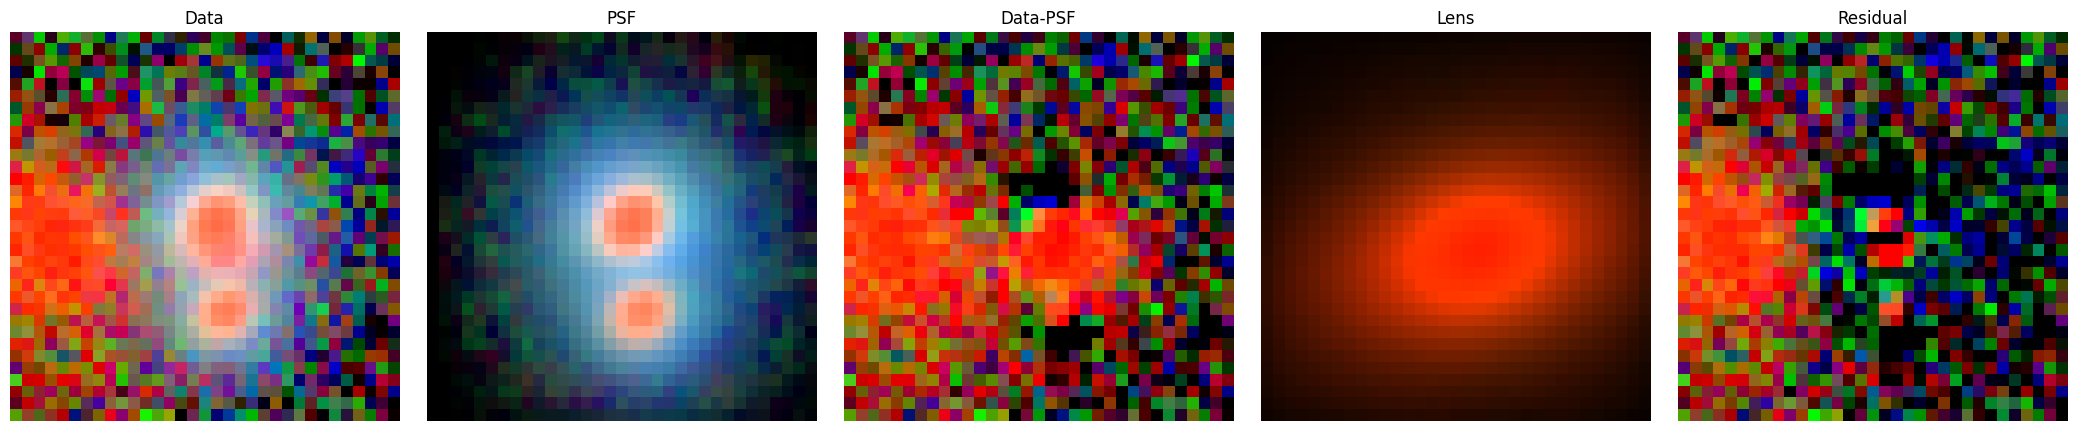

[lensviz] 已保存小图与拼接大图到: /home/zizhao/jasmine-worksapce/FH2/result-single-model/ra_148.52904_dec_-0.37368


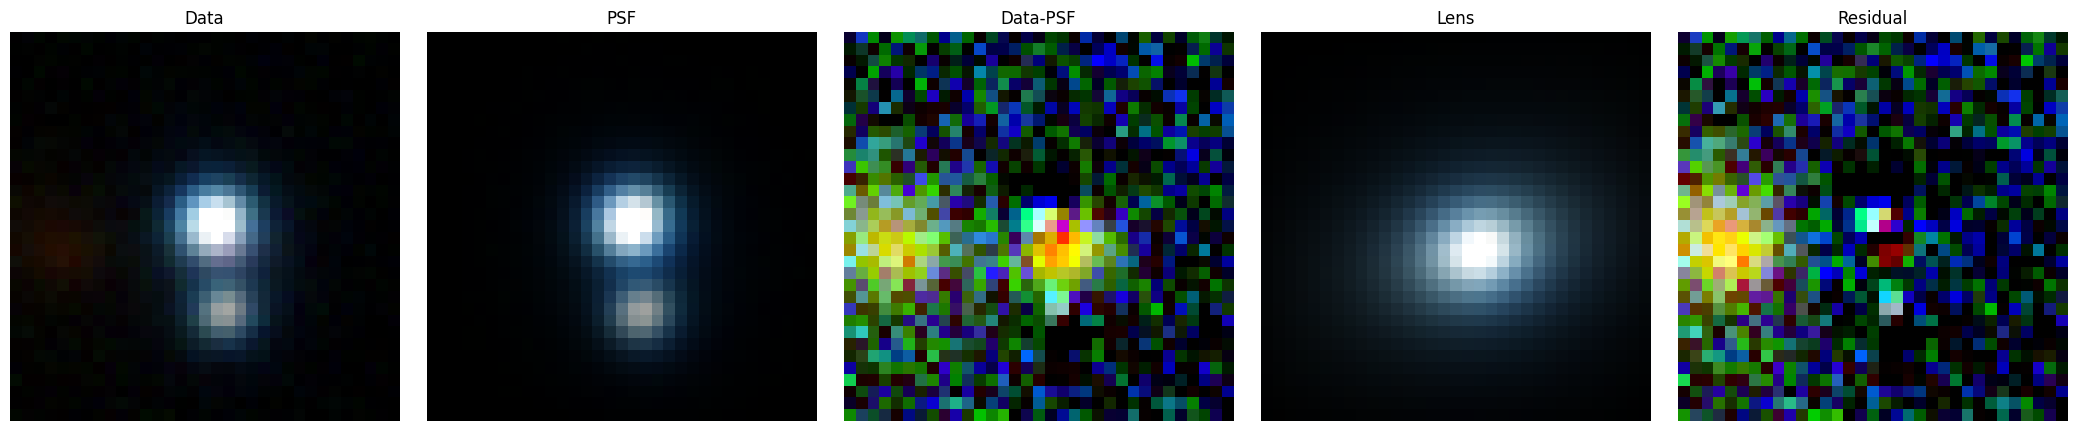

[lensviz] 已保存小图与拼接大图到: /home/zizhao/jasmine-worksapce/FH2/result-single-model/ra_148.52904_dec_-0.37368


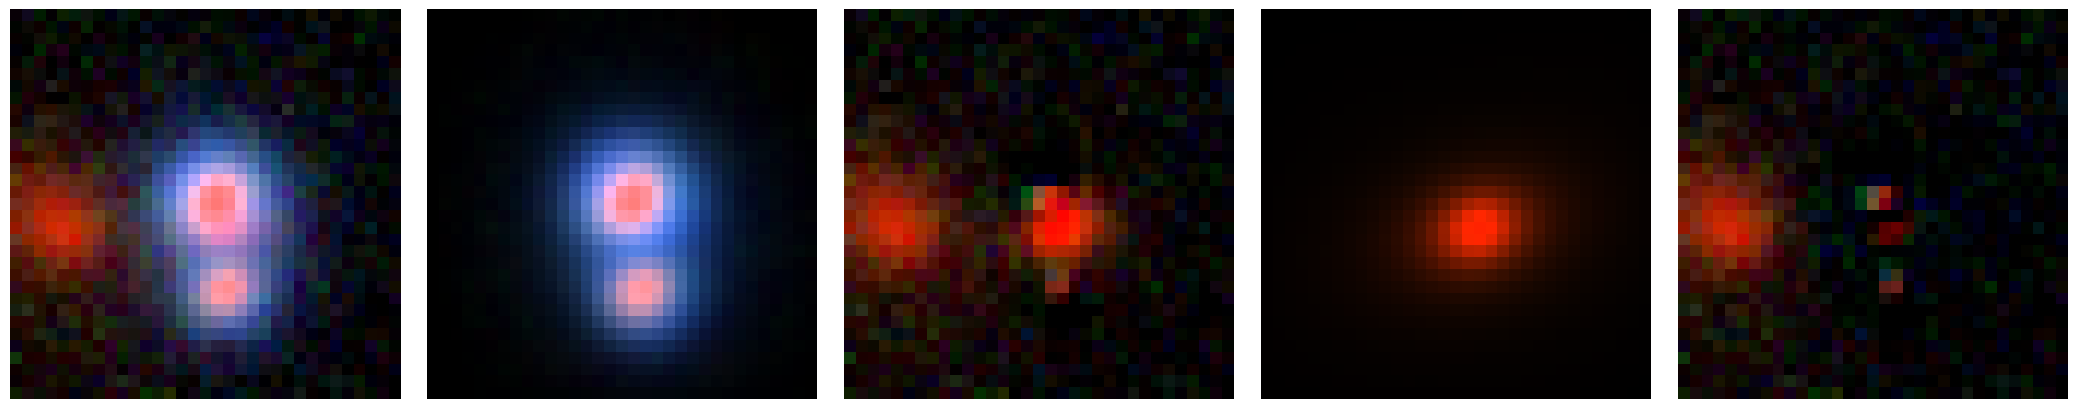

In [34]:
 
# ---------- 结果可视化 ----------
# 1. 创建可视化器（自动搜寻 results/ra_xx_dec_xx 目录）
viz = lv.LensViz(
    ra=ra_cen, dec=dec_cen,
    results_root=Path("result-single-model"),   # 根目录
    bands=("g", "r", "z"),          # 需要处理的波段
    
    stretch_kind="linear",          # or 'asinh'
)

# 2. 读取 FITS 并构建内部 band_data 字典
viz.load()

# 3. 单波段六面板图（自动保存到 results_dir）
viz.plot_all()         # 依次画 g/r/z

# 4. 一键生成 RGB 画廊
viz.show_rgb_gallery(
    components=('data','psf','data_minus_psf','lens','residual'),
    method="lupton",            # 或 'asinh'
    save_prefix="grz_rgb"       # 会批量写入 PNG
)

viz.show_rgb_gallery(
    components=('data','psf','data_minus_psf','lens','residual'),
    method="asinh",            # 或 'asinh'
    save_prefix="grz_rgb"       # 会批量写入 PNG
)

viz.show_rgb_gallery(
    components=('data','psf','data_minus_psf','lens','residual'),
    method="humvi",
    Q=8, alpha=1, scales=(1.8, 2.0, 3.0),
    save_prefix="grz_rgb_humvi",
    show_titles=False,         # 显示列标题
    title_fontsize=25         # 可选，默认已是 12
)

In [40]:
# begin chain process
def flux_to_mag(flux):
    mag = -2.5*np.log10(flux)+27
    return mag

In [41]:
import lenstronomy.LensModel.Profiles.sersic_utils as sersic_utils
from lenstronomy.Util.param_util import ellipticity2phi_q

In [42]:
samples_mcmc=np.loadtxt(save_dir/"samples_mcmc.txt")
dist_mcmc=np.loadtxt(save_dir/"dist_mcmc.txt")
with open(save_dir/'kwargs_result.json') as f:
    kwargs_result_new=json.load(f)
with open(save_dir/'param_mcmc.txt') as f:
    param_mcmc=json.load(f)

In [43]:
SersicUtil=sersic_utils.SersicUtil()
def param_chain_reconstruction(i):
    #重构
    kwargs_result_new['kwargs_lens_light'][0]['R_sersic']=samples_mcmc[i,param_mcmc.index('R_sersic_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][0]['n_sersic']=4
    kwargs_result_new['kwargs_lens_light'][0]['e1']=samples_mcmc[i,param_mcmc.index('e1_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][0]['e2']=samples_mcmc[i,param_mcmc.index('e2_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][0]['center_x']=samples_mcmc[i,param_mcmc.index('center_x_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][0]['center_y']=samples_mcmc[i,param_mcmc.index('center_y_lens_light0')]

    kwargs_result_new['kwargs_lens_light'][1]['R_sersic']=samples_mcmc[i,param_mcmc.index('R_sersic_lens_light1')]
    kwargs_result_new['kwargs_lens_light'][1]['n_sersic']=4
    kwargs_result_new['kwargs_lens_light'][1]['e1']=samples_mcmc[i,param_mcmc.index('e1_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][1]['e2']=samples_mcmc[i,param_mcmc.index('e2_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][1]['center_x']=samples_mcmc[i,param_mcmc.index('center_x_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][1]['center_y']=samples_mcmc[i,param_mcmc.index('center_y_lens_light0')]

    kwargs_result_new['kwargs_lens_light'][2]['R_sersic']=samples_mcmc[i,param_mcmc.index('R_sersic_lens_light2')]
    kwargs_result_new['kwargs_lens_light'][2]['n_sersic']=4
    kwargs_result_new['kwargs_lens_light'][2]['e1']=samples_mcmc[i,param_mcmc.index('e1_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][2]['e2']=samples_mcmc[i,param_mcmc.index('e2_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][2]['center_x']=samples_mcmc[i,param_mcmc.index('center_x_lens_light0')]
    kwargs_result_new['kwargs_lens_light'][2]['center_y']=samples_mcmc[i,param_mcmc.index('center_y_lens_light0')]

    d=kwargs_result_new['kwargs_ps'][0]

    d['ra_image'][0],d['ra_image'][1]=samples_mcmc[i,param_mcmc.index("ra_image")],samples_mcmc[i,(param_mcmc.index("ra_image")+1)]
    d['dec_image'][0],d['dec_image'][1]=samples_mcmc[i,param_mcmc.index("dec_image")],samples_mcmc[i,(param_mcmc.index("dec_image")+1)]

    phi_lens,q_lens=ellipticity2phi_q(samples_mcmc[i,param_mcmc.index('e1_lens_light0')],samples_mcmc[i,param_mcmc.index('e2_lens_light0')])
    phi_lens=np.rad2deg(phi_lens)

    lens_light_reconstruction=Reconstruction(multi_band_list,kwargs_model,kwargs_result_new,multi_band_type='multi-linear',kwargs_likelihood=kwargs_likelihood,verbose=False)

    lens_light_image_model_g=lens_light_reconstruction.band_setup(band_index=0)
    lens_light_image_model_r=lens_light_reconstruction.band_setup(band_index=1)
    lens_light_image_model_z=lens_light_reconstruction.band_setup(band_index=2)

    kwargs_reconstructed_g=lens_light_image_model_g[1]
    kwargs_reconstructed_r=lens_light_image_model_r[1]
    kwargs_reconstructed_z=lens_light_image_model_z[1]

    #重构完毕，读取amp
    sersic_amp_g=kwargs_reconstructed_g['kwargs_lens_light'][0]['amp']
    sersic_amp_r=kwargs_reconstructed_r['kwargs_lens_light'][0]['amp']
    sersic_amp_z=kwargs_reconstructed_z['kwargs_lens_light'][0]['amp']

    ps1_amp_g,ps2_amp_g=kwargs_reconstructed_g['kwargs_ps'][0]["point_amp"]
    ps1_amp_r,ps2_amp_r=kwargs_reconstructed_r['kwargs_ps'][0]["point_amp"]
    ps1_amp_z,ps2_amp_z=kwargs_reconstructed_z['kwargs_ps'][0]["point_amp"]

    #amp 转为星等

    flux_lens_g= SersicUtil.total_flux(sersic_amp_g, kwargs_result_new['kwargs_lens_light'][0]['R_sersic'], kwargs_result_new['kwargs_lens_light'][0]['n_sersic'] ,kwargs_result_new['kwargs_lens_light'][0]['e1'], kwargs_result_new['kwargs_lens_light'][0]['e2'])

    flux_lens_r= SersicUtil.total_flux(sersic_amp_r, kwargs_result_new['kwargs_lens_light'][1]['R_sersic'], kwargs_result_new['kwargs_lens_light'][1]['n_sersic'] ,kwargs_result_new['kwargs_lens_light'][1]['e1'], kwargs_result_new['kwargs_lens_light'][1]['e2'])

    flux_lens_z= SersicUtil.total_flux(sersic_amp_z, kwargs_result_new['kwargs_lens_light'][2]['R_sersic'], kwargs_result_new['kwargs_lens_light'][2]['n_sersic'] ,kwargs_result_new['kwargs_lens_light'][2]['e1'], kwargs_result_new['kwargs_lens_light'][2]['e2'])
    
    if flux_lens_g<0:flux_lens_g=1e-9
    if flux_lens_r<0:flux_lens_r=1e-9
    if flux_lens_z<0:flux_lens_z=1e-9

    mag_lens_g=flux_to_mag(flux_lens_g)
    mag_lens_r=flux_to_mag(flux_lens_r)
    mag_lens_z=flux_to_mag(flux_lens_z)

    mag_amp1_g,mag_amp2_g=flux_to_mag([ps1_amp_g,ps2_amp_g])
    mag_amp1_r,mag_amp2_r=flux_to_mag([ps1_amp_r,ps2_amp_r])
    mag_amp1_z,mag_amp2_z=flux_to_mag([ps1_amp_z,ps2_amp_z])
    
    rs_g=kwargs_result_new['kwargs_lens_light'][0]['R_sersic']
    rs_r=kwargs_result_new['kwargs_lens_light'][1]['R_sersic']
    rs_z=kwargs_result_new['kwargs_lens_light'][2]['R_sersic']
    
    xgal,ygal=kwargs_result_new['kwargs_lens_light'][0]['center_x'],kwargs_result_new['kwargs_lens_light'][0]['center_y']
    xps1,yps1=d['ra_image'][0],d['dec_image'][0]
    xps2,yps2=d['ra_image'][1],d['dec_image'][1]
    

    return mag_lens_g,mag_lens_r,mag_lens_z,\
        mag_amp1_g,mag_amp2_g,\
        mag_amp1_r,mag_amp2_r,\
        mag_amp1_z,mag_amp2_z,\
        phi_lens,q_lens,\
        rs_g,rs_r,rs_z,\
        xgal,ygal,xps1,yps1,xps2,yps2
        

In [44]:
Nmcmc=samples_mcmc.shape[0]
pool=multiprocessing.Pool(100)
res=pool.map(param_chain_reconstruction,np.arange(Nmcmc))
pool.close()
pool.join()
np.savetxt(save_dir/'param_chain.txt',res)

/home/zizhao/anaconda3/envs/py38/lib/python3.8/site-packages/lenstronomy/Data/psf.py:60: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn('Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.')
/home/zizhao/anaconda3/envs/py38/lib/python3.8/site-packages/lenstronomy/Data/psf.py:60: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn('Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.')
/home/zizhao/anaconda3/envs/py38/lib/python3.8/site-packages/lenstronomy/Data/psf.py:60: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn('Input PSF model has at least one negative element, whi

In [45]:
title=["mag_lens_g","mag_lens_r","mag_lens_z",\
        "mag_amp1_g","mag_amp2_g",\
        "mag_amp1_r","mag_amp2_r",\
        "mag_amp1_z","mag_amp2_z",\
        "phi_lens","q_lens",\
        "rs_g","rs_r","rs_z",\
        "xgal","ygal","xps1","yps1","xps2","yps2"]
chain_df=pd.read_csv(save_dir/'param_chain.txt',sep=' ',names=title)


In [46]:
chain_df.describe()

,mag_lens_g,mag_lens_r,mag_lens_z,mag_amp1_g,mag_amp2_g,mag_amp1_r,mag_amp2_r,mag_amp1_z,mag_amp2_z,phi_lens,q_lens,rs_g,rs_r,rs_z,xgal,ygal,xps1,yps1,xps2,yps2
count,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000
mean,35.330925,23.404543,21.725988,22.102127,20.956823,22.081069,20.915423,21.932786,20.629491,13.927133,0.564669,1.034151,1.003427,0.852969,0.313929,-0.357360,0.279087,-1.224911,0.142516,0.049317
std,8.556069,0.107278,0.022075,0.002788,0.003280,0.001933,0.002527,0.001238,0.001579,0.703128,0.009895,0.001351,0.002198,0.000972,0.004151,0.000811,0.002006,0.002936,0.000895,0.002676
min,28.055207,23.312226,21.680343,22.093486,20.947289,22.075429,20.909327,21.928319,20.625507,10.442450,0.515363,1.028759,0.992307,0.848887,0.273313,-0.365577,0.273931,-1.230522,0.139916,0.042492
25%,29.584855,23.340517,21.714608,22.099595,20.953250,22.079168,20.912580,21.932380,20.627870,13.520838,0.559823,1.033412,1.002127,0.852427,0.313935,-0.357560,0.277825,-1.226940,0.141952,0.046255
50%,30.610764,23.344599,21.716443,22.103497,20.958648,22.082015,20.916805,21.932945,20.630275,13.892704,0.565985,1.033930,1.003105,0.852953,0.314409,-0.357251,0.278482,-1.225746,0.142308,0.050650
75%,49.500000,23.508065,21.719136,22.103895,20.958823,22.082318,20.917006,21.933450,20.630507,14.272626,0.570016,1.034518,1.004721,0.853449,0.315037,-0.357003,0.279908,-1.223677,0.142949,0.051048
max,49.500000,23.736085,21.794707,22.105216,20.959446,22.083551,20.917704,21.938027,20.631308,17.562094,0.600983,1.041359,1.013303,0.859763,0.316262,-0.355177,0.286033,-1.213103,0.146280,0.052403


In [47]:
sigma_sys_floor = 0.02
mag_lens_gmed=np.median(chain_df["mag_lens_g"])
mag_lens_rmed=np.median(chain_df["mag_lens_r"])
mag_lens_zmed=np.median(chain_df["mag_lens_z"])
mag_lens_gerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_lens_g"]))
mag_lens_rerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_lens_r"]))
mag_lens_zerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_lens_z"]))
mag_amp1_gmed=np.median(chain_df["mag_amp1_g"])
mag_amp1_rmed=np.median(chain_df["mag_amp1_r"])
mag_amp1_zmed=np.median(chain_df["mag_amp1_z"])
mag_amp1_gerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_amp1_g"]))
mag_amp1_rerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_amp1_r"]))
mag_amp1_zerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_amp1_z"]))

mag_amp2_gmed=np.median(chain_df["mag_amp2_g"])
mag_amp2_rmed=np.median(chain_df["mag_amp2_r"])
mag_amp2_zmed=np.median(chain_df["mag_amp2_z"])
mag_amp2_gerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_amp2_g"]))
mag_amp2_rerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_amp2_r"]))
mag_amp2_zerr=np.hypot(sigma_sys_floor,np.std(chain_df["mag_amp2_z"]))

rs_g_med=np.median(chain_df["rs_g"])
rs_r_med=np.median(chain_df["rs_r"])
rs_z_med=np.median(chain_df["rs_z"])
rs_g_std=np.std(chain_df["rs_g"])
rs_r_std=np.std(chain_df["rs_r"])
rs_z_std=np.std(chain_df["rs_z"])

q_med=np.median(chain_df["q_lens"])
phi_med=np.median(chain_df["phi_lens"])

q_std=np.std(chain_df["q_lens"])
phi_std=np.std(chain_df["phi_lens"])

xgal_med=np.median(chain_df["xgal"])
ygal_med=np.median(chain_df["ygal"])
xps1_med=np.median(chain_df["xps1"])
yps1_med=np.median(chain_df["yps1"])
xps2_med=np.median(chain_df["xps2"])
yps2_med=np.median(chain_df["yps2"])

xgal_std=np.std(chain_df["xgal"])
ygal_std=np.std(chain_df["ygal"])
xps1_std=np.std(chain_df["xps1"])
yps1_std=np.std(chain_df["yps1"])
xps2_std=np.std(chain_df["xps2"])
yps2_std=np.std(chain_df["yps2"])

In [48]:
# —— 组装成单行 DataFrame —— #
data = {
    "mag_lens_gmed":   [mag_lens_gmed],
    "mag_lens_gerr":   [mag_lens_gerr],
    "mag_lens_rmed":   [mag_lens_rmed],
    "mag_lens_rerr":   [mag_lens_rerr],
    "mag_lens_zmed":   [mag_lens_zmed],
    "mag_lens_zerr":   [mag_lens_zerr],
    "mag_amp1_gmed":   [mag_amp1_gmed],
    "mag_amp1_gerr":   [mag_amp1_gerr],
    "mag_amp1_rmed":   [mag_amp1_rmed],
    "mag_amp1_rerr":   [mag_amp1_rerr],
    "mag_amp1_zmed":   [mag_amp1_zmed],
    "mag_amp1_zerr":   [mag_amp1_zerr],
    "mag_amp2_gmed":   [mag_amp2_gmed],
    "mag_amp2_gerr":   [mag_amp2_gerr],
    "mag_amp2_rmed":   [mag_amp2_rmed],
    "mag_amp2_rerr":   [mag_amp2_rerr],
    "mag_amp2_zmed":   [mag_amp2_zmed],
    "mag_amp2_zerr":   [mag_amp2_zerr],
    "rs_g_med":        [rs_g_med],
    "rs_g_std":        [rs_g_std],
    "rs_r_med":        [rs_r_med],
    "rs_r_std":        [rs_r_std],
    "rs_z_med":        [rs_z_med],
    "rs_z_std":        [rs_z_std],
    "q_med":        [q_med],
    "q_std":        [q_std],
    "phi_med":      [phi_med],
    "phi_std":      [phi_std],
    "xgal_med":        [xgal_med],
    "xgal_std":        [xgal_std],
    "ygal_med":        [ygal_med],
    "ygal_std":        [ygal_std],
    "xps1_med":        [xps1_med],
    "xps1_std":        [xps1_std],
    "yps1_med":        [yps1_med],
    "yps1_std":        [yps1_std],
    "xps2_med":        [xps2_med],
    "xps2_std":        [xps2_std],
    "yps2_med":        [yps2_med],
    "yps2_std":        [yps2_std],
    "ra_c": [ra_cen],
    "dec_c": [dec_cen],
}

paper_tab = pd.DataFrame(data)

# —— 保存到 CSV —— #
paper_tab.to_csv(save_dir/f"paper_tab{jname}.csv", index=False, float_format="%.5f")
print("Saved ➜ paper_tab.csv")

Saved ➜ paper_tab.csv
